In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd
import glob
import data_utils_celeba


import numpy as np
import pandas as pd
import os

In [2]:
# Root directory for dataset
dataroot = 'C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep'

# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

In [3]:
attributes = pd.read_csv('C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\list_attr_celeba.txt', sep=" ")
attributes.drop('Unnamed: 41',axis=1, inplace=True)
partition = pd.read_csv('C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\list_eval_partition.txt', sep=" ", header=None, names=['im_id','partition'])
matched = attributes.set_index('im_id').join(partition.set_index('im_id'))

In [4]:
train = matched[matched['partition']==0]
valid = matched[matched['partition']==1]
test = matched[matched['partition']==2]
train[0:1000].to_csv('train.csv')
valid[0:1000].to_csv('valid.csv')
test[0:1000].to_csv('test.csv')

In [3]:
IMAGE_SHAPE = (178,218)
# Paths to data
TRAIN_PATH = "C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\AlgorithmicFairness\\train.csv" 
VALID_PATH = "C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\AlgorithmicFairness\\valid.csv" 
TEST_PATH = "C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\AlgorithmicFairness\\test.csv" 
IMAGE_PATHS = glob.glob("C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\celebA\\*.jpg")
TARGET_COL = 'Male'

# train holds both X (input) and t (target/truth)
data = data_utils_celeba.load_data(train_path=TRAIN_PATH,
                            valid_path = VALID_PATH,
                            test_path=TEST_PATH,
                            image_paths=IMAGE_PATHS,
                            target_col = TARGET_COL,
                            image_shape=IMAGE_SHAPE[:2])

Loading training data
	0 of 1000
Loading validation data
	0 of 1000
Loading test data
	0 of 1000


In [4]:
NUM_CLASSES = 2

dummy_batch_gen = data_utils_celeba.batch_generator(data, batch_size=batch_size, num_classes=NUM_CLASSES, num_iterations=5e3, num_features=40, seed=42)

In [5]:
train_batch = next(dummy_batch_gen.gen_train())
valid_batch, i = next(dummy_batch_gen.gen_valid())
test_batch, i = next(dummy_batch_gen.gen_test())

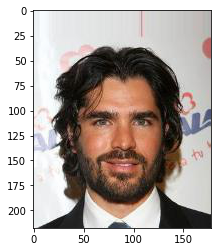

In [14]:
plt.imshow(np.transpose(vutils.make_grid(torch.Tensor(valid_batch['images'][1]), padding=2, normalize=True).cpu(),(0,1,2)))